In [1]:
import torch
print(torch.__version__)

2.5.1


In [7]:
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
!pip install torchsummary

In [10]:
df = pd.read_csv('E:/riceClassification.csv')

In [15]:
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [16]:
df.dropna(inplace=True)
df.drop(['id'],axis=1,inplace=True)

In [17]:
df.shape

(18185, 11)

In [18]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [19]:
df['Class'].unique()

array([1, 0], dtype=int64)

In [23]:
df['Class'].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [24]:
# The values in the dataset are extremely huge and the weigths of the neural network are
# small and when the weights are the neural network are multiplied with these values, the values
# become large and the computation becomes expensive
# So we do normalization by dividing the respective columns with the largest value which
# makes the largest value as 1

In [25]:
# we will need the original values for the inferece so we create a copy

In [26]:
original_df = df.copy()

In [27]:
# use abs for negative values ignoration

In [28]:
for column in df.columns:
    df[column] = df[column]/df[column].abs().max()
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [77]:
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [79]:
# We are keeping the 70 data for training and 30 for testing and then keeping the
# remaining into 50 50 percent 15 of the original for test and same for validation

In [80]:
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

In [81]:
X_train.shape

(12729, 10)

In [35]:
y_train.shape

(12729,)

In [37]:
X_test.shape

(2728, 10)

In [38]:
X_val.shape

(2728, 10)

In [82]:
class dataset(Dataset):
    def __init__(self,X,Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self,index):
        return self.X[index], self.Y[index]

In [43]:
# I’m teaching PyTorch how to look at my data one sample at a time and give it out in batches
"""
🎯 Why Use This Custom Dataset Class in PyTorch?
✅ 1. To Feed Data Into the Model Properly
PyTorch models expect data in batches and in tensor format.

Raw data (like from CSV or NumPy) must be converted to tensors.

This class does that conversion once and for all.

✅ 2. To Use the PyTorch DataLoader
The DataLoader:

Loads your data in mini-batches (e.g., 32 samples at a time).

Shuffles the data automatically for training.

Can load data in parallel using multiple CPU cores.

But to use DataLoader, you must give it a Dataset object — and that’s what our class does!

✅ 3. For Cleaner, Scalable Code
Imagine later you want to:

Normalize inputs

Load from image folders or CSVs

Augment data (for training)

Support different file formats

If you have a custom dataset class, you just update it once — and everything else (training loop, model, etc.) stays the same.

You’d have to:

Convert data to tensors manually

Slice batches by hand

Shuffle manually using np.random.shuffle

Move everything to device each time

Handle indexing errors, type issues, etc.
"""

'\n🎯 Why Use This Custom Dataset Class in PyTorch?\n✅ 1. To Feed Data Into the Model Properly\nPyTorch models expect data in batches and in tensor format.\n\nRaw data (like from CSV or NumPy) must be converted to tensors.\n\nThis class does that conversion once and for all.\n\n✅ 2. To Use the PyTorch DataLoader\nThe DataLoader:\n\nLoads your data in mini-batches (e.g., 32 samples at a time).\n\nShuffles the data automatically for training.\n\nCan load data in parallel using multiple CPU cores.\n\nBut to use DataLoader, you must give it a Dataset object — and that’s what our class does!\n\n✅ 3. For Cleaner, Scalable Code\nImagine later you want to:\n\nNormalize inputs\n\nLoad from image folders or CSVs\n\nAugment data (for training)\n\nSupport different file formats\n\nIf you have a custom dataset class, you just update it once — and everything else (training loop, model, etc.) stays the same.\n\nYou’d have to:\n\nConvert data to tensors manually\n\nSlice batches by hand\n\nShuffle manu

In [83]:
training_data = dataset(X_train,y_train)
validation_data = dataset(X_val,y_val)
testing_data = dataset(X_test,y_test)

In [44]:
# we use dataloader to loop through the specific amount of batches

In [84]:
train_dataloader = DataLoader(training_data, batch_size = 8, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 8, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 8, shuffle = True)

In [48]:
# we loop through the batch size for every iteration using dataloader, batch size =8
# means 8 rows, if we change the batch size we loop through that number of rows for 
# every iteration

In [64]:
for x,y in train_dataloader:
    print(x)

tensor([[0.4989, 0.8090, 0.5358, 0.9872, 0.4742, 0.7063, 0.8867, 0.6321, 0.6848,
         0.8566],
        [0.7692, 0.7914, 0.8515, 0.9047, 0.7316, 0.8771, 0.8200, 0.6941, 0.8756,
         0.5273],
        [0.8663, 0.9064, 0.8319, 0.9418, 0.8368, 0.9308, 0.6775, 0.7654, 0.8110,
         0.6182],
        [0.9345, 0.8887, 0.9091, 0.9179, 0.8873, 0.9667, 0.8568, 0.7687, 0.8674,
         0.5546],
        [0.8088, 0.8520, 0.8250, 0.9307, 0.7692, 0.8993, 0.6253, 0.7308, 0.8304,
         0.5860],
        [0.6498, 0.8922, 0.6400, 0.9789, 0.6172, 0.8061, 0.5719, 0.7093, 0.7083,
         0.7910],
        [0.8919, 0.8809, 0.8842, 0.9225, 0.8527, 0.9444, 0.6650, 0.7580, 0.8512,
         0.5652],
        [0.5821, 0.8613, 0.5920, 0.9835, 0.5542, 0.7629, 0.5416, 0.6780, 0.6944,
         0.8254]])
tensor([[0.8725, 0.8590, 0.8790, 0.9179, 0.8217, 0.9341, 0.6766, 0.7374, 0.8798,
         0.5545],
        [0.5889, 0.8585, 0.6029, 0.9812, 0.5704, 0.7674, 0.7486, 0.6916, 0.6753,
         0.8078],
        [

In [85]:
# this means the first line that the class inherits all the modules function from the nn
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):   
        x=self.input_layer(x)
        x=self.linear(x)
        x=self.sigmoid(x)
        return x

model = MyModel().to(device)

In [55]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [86]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [87]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs,labels = data
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_train += batch_loss.item()
        acc = ((prediction).round() == labels).sum().item()
        total_acc_train += acc
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()
            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc
    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_validation_plot.append(round(total_loss_val/1000,4))

    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100,4))
    print(f'''Epoch no: {epoch+1} Train Loss: {round(total_loss_train/100, 4)} Train Accuracy
           {round(total_acc_train/training_data.__len__()*100,4)}
               Validation loss: {round(total_loss_val/1000,4)}
               Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100,4)}''')    
    print('='*10)

Epoch no: 1 Train Loss: 11.2944 Train Accuracy
           55.1497
               Validation loss: 0.2374
               Validation Accuracy: 54.1789
Epoch no: 2 Train Loss: 10.7803 Train Accuracy
           55.2596
               Validation loss: 0.2237
               Validation Accuracy: 54.7287
Epoch no: 3 Train Loss: 9.9269 Train Accuracy
           79.6213
               Validation loss: 0.2015
               Validation Accuracy: 94.7214
Epoch no: 4 Train Loss: 8.7547 Train Accuracy
           96.072
               Validation loss: 0.1743
               Validation Accuracy: 96.2977
Epoch no: 5 Train Loss: 7.4195 Train Accuracy
           97.3682
               Validation loss: 0.1454
               Validation Accuracy: 97.0308
Epoch no: 6 Train Loss: 6.0861 Train Accuracy
           97.7767
               Validation loss: 0.1183
               Validation Accuracy: 97.2141
Epoch no: 7 Train Loss: 4.8759 Train Accuracy
           98.1224
               Validation loss: 0.0946
       

In [58]:
# we are looping through 2 things the epoch and the batch first the batch is iterated and the 
# loss is calculated then again the values are kept 0 for the next epoch

In [91]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in testing_dataloader:
        inputs,labels = data
        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test

        acc = ((prediction).round() == labels).sum().item()

        total_acc_test += acc

print('Accuracy: ', round(total_acc_test/testing_data.__len__() * 100, 4))

Accuracy:  98.607


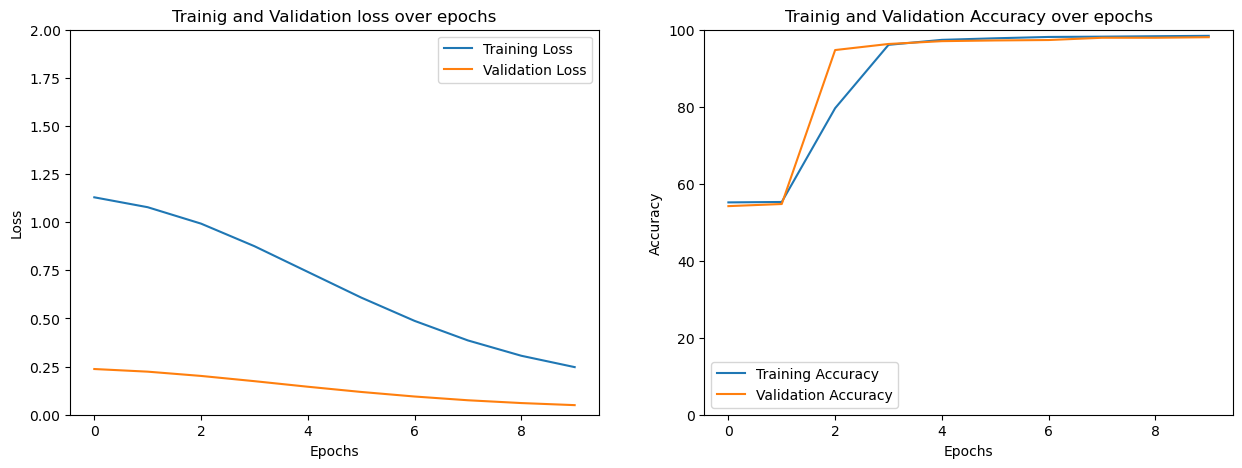

In [97]:
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title('Trainig and Validation loss over epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0,2)
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_validation_plot, label = 'Validation Accuracy')
axs[1].set_title('Trainig and Validation Accuracy over epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0,100)
axs[1].legend()

plt.show()

In [99]:
Area = 2353/original_df['Area'].abs().max()
MajorAxisLength = 81/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 42/original_df['MinorAxisLength'].abs().max()
Eccentricity = 32/original_df['Eccentricity'].abs().max()
ConvexArea = 12/original_df['ConvexArea'].abs().max()
EquivDiameter = 33/original_df['EquivDiameter'].abs().max()
Extent = 98/original_df['Extent'].abs().max()
Perimeter = 927/original_df['Perimeter'].abs().max()
Roundness = 677/original_df['Roundness'].abs().max()
AspectRation = 24/original_df['AspectRation'].abs().max()

my_prediction = model(torch.tensor([Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,
                   Perimeter,Roundness,AspectRation],dtype=torch.float32).to(device))

In [101]:
my_prediction.item()

0.0